##### Copyright 2019 Qiyang Hu

In [0]:
#@title Licensed under MIT License (the "License")
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://huqy.github.io/idre_learning_machine_learning/LICENSE.md
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

The major code in this notebook about the data augmentation and the CNN model is mainly adopted and based from Google's Udacity [Course](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c02_dogs_vs_cats_with_augmentation.ipynb).

# Importing Packages

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print(tf.version.VERSION)

2.0.0


# Mount Google Drive

For saving the training of the model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Download Data from Kaggle

In [5]:
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [6]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [7]:
!kaggle competitions list -s dogs-vs-cats

ref                                 deadline             category       reward  teamCount  userHasEntered  
----------------------------------  -------------------  ----------  ---------  ---------  --------------  
dogs-vs-cats                        2014-02-01 23:59:00  Playground       Swag        215            True  
dogs-vs-cats-redux-kernels-edition  2017-03-02 23:59:00  Playground  Knowledge       1314            True  


In [8]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content

 98% 266M/271M [00:06<00:00, 42.6MB/s]
100% 271M/271M [00:06<00:00, 44.5MB/s]
 99% 536M/544M [00:11<00:00, 38.3MB/s]
100% 544M/544M [00:11<00:00, 49.9MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 118MB/s]


In [9]:
zip_train_dir = tf.keras.utils.get_file('train.zip', origin='file:///content/train.zip', extract=True)
zip_test_dir = tf.keras.utils.get_file('test.zip', origin='file:///content/test.zip', extract=True)

284483584/284478493 [==============================] - 1s 0us/step


In [0]:
train_orig_dir = os.path.join(os.path.dirname(zip_train_dir), 'train')
base_dir = "/content"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

os.makedirs(train_cats_dir)
os.makedirs(train_dogs_dir)
os.makedirs(validation_cats_dir)
os.makedirs(validation_dogs_dir)

In [0]:
filenames = os.listdir(train_orig_dir)
min_index_validation = int(len(filenames)/3)
categories = []
for filename in filenames:
    src = os.path.join(train_orig_dir, filename)
    category = filename.split('.')[0]
    imageId  = filename.split('.')[1]
    extension = filename.split('.')[2]
    if category == 'dog':
        if int(imageId) < min_index_validation:
            dst = os.path.join(train_dogs_dir, imageId+'.'+extension)
        else:
            dst = os.path.join(validation_dogs_dir, imageId+'.'+extension)
    else:
        if int(imageId) < min_index_validation:
            dst = os.path.join(train_cats_dir, imageId+'.'+extension)
        else:
            dst = os.path.join(validation_cats_dir, imageId+'.'+extension)
    copyfile(src, dst)

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [13]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 8333
total training dog images: 8333
total validation cat images: 4167
total validation dog images: 4167
--
Total training images: 16666
Total validation images: 8334


In [0]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Data Augmentation

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Flipping the image horizontally

In [16]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 16666 images belonging to 2 classes.


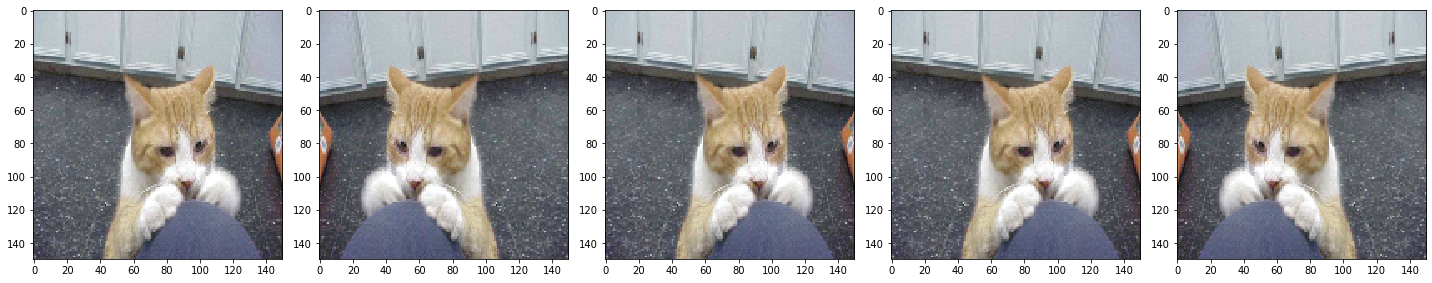

In [17]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Rotating the image

In [18]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 16666 images belonging to 2 classes.


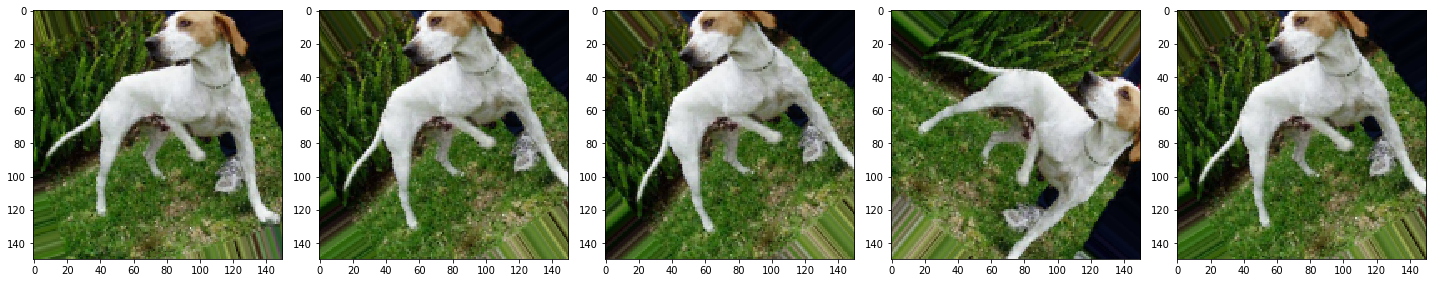

In [19]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Applying Zoom

In [20]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


Found 16666 images belonging to 2 classes.


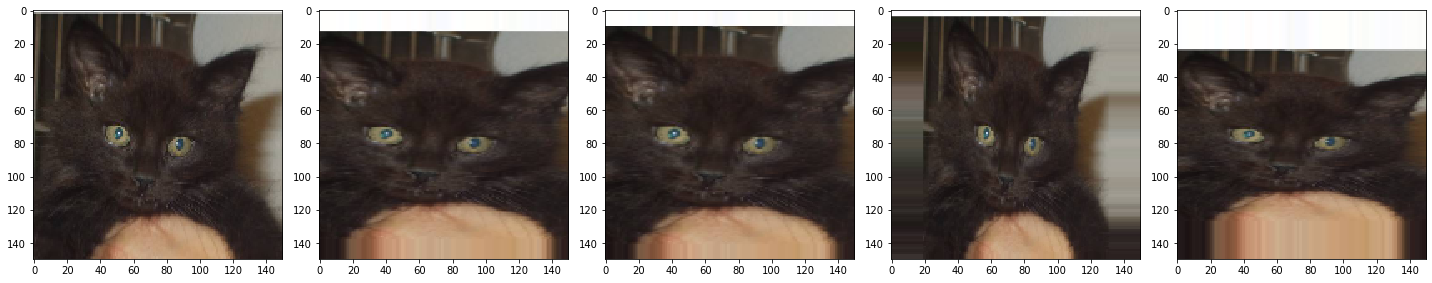

In [21]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Putting it all together

In [22]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 16666 images belonging to 2 classes.


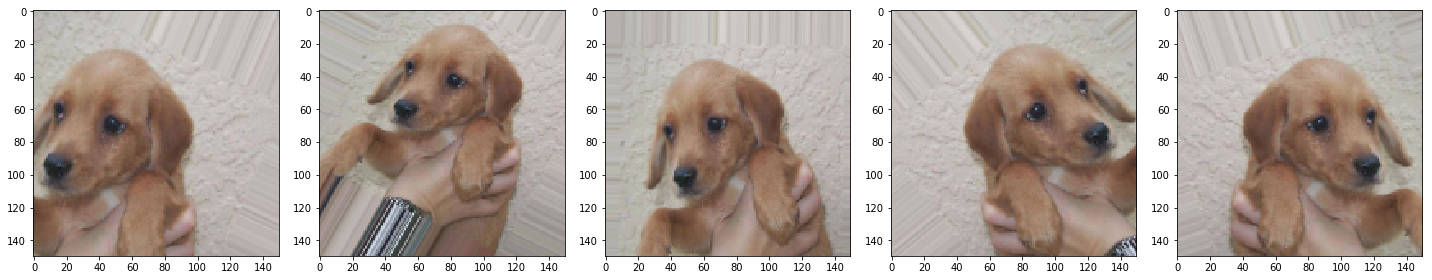

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Validation Data generator

In [23]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 8334 images belonging to 2 classes.


## Model Creation

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

NOTE: Skip to load the model if time is short.

In [0]:
epochs=200
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/200
167/167 [==============================] - 180s 1s/step - loss: 0.6807 - accuracy: 0.5562 - val_loss: 0.6386 - val_accuracy: 0.6371
Epoch 2/200
167/167 [==============================] - 167s 1s/step - loss: 0.6441 - accuracy: 0.6189 - val_loss: 0.5903 - val_accuracy: 0.6789
Epoch 3/200
167/167 [==============================] - 168s 1s/step - loss: 0.6063 - accuracy: 0.6712 - val_loss: 0.5672 - val_accuracy: 0.6986
Epoch 4/200
167/167 [==============================] - 168s 1s/step - loss: 0.5774 - accuracy: 0.6924 - val_loss: 0.5104 - val_accuracy: 0.7514
Epoch 5/200
167/167 [==============================] - 168s 1s/step - loss: 0.5493 - accuracy: 0.7169 - val_loss: 0.4711 - val_accuracy: 0.7863
Epoch 6/200
167/167 [==============================] - 168s 1s/step - loss: 0.5280 - accuracy: 0.7347 - val_loss: 0.4664 - val_accuracy: 0.7819
Epoch 7/200
167/167 [==============================] - 166s 993ms/step - loss: 0.4979 - accuracy: 0.7607 - val_loss: 0.4163 - val_accura

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

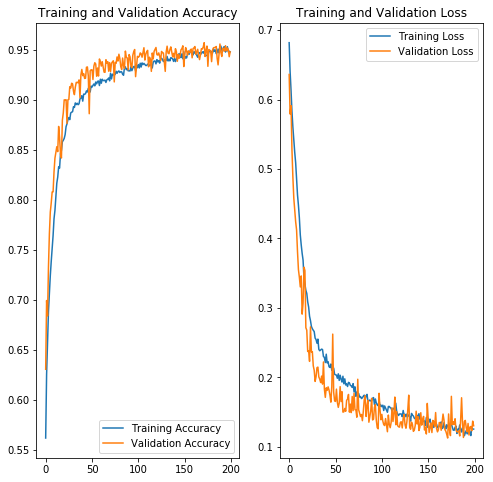

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Save the model

In [0]:
t = time.time()
savedmodel_dir = "/content/drive/My Drive/saved_model/dogcats/{}".format(int(t))
print(savedmodel_dir)

In [0]:
model.save(savedmodel_dir) 

In [0]:
os.listdir(savedmodel_dir)

### Load the model

In [27]:
# load the model saved before
t = 1570761067
savedmodel_dir = "/content/drive/My Drive/saved_model/dogcats/{}".format(int(t))
new_model = tf.keras.models.load_model(savedmodel_dir)
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Keep training if not finished

In [35]:
epochs=2
history = new_model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/2
167/167 [==============================] - 188s 1s/step - loss: 0.1237 - accuracy: 0.9511 - val_loss: 0.1145 - val_accuracy: 0.9564
Epoch 2/2
167/167 [==============================] - 183s 1s/step - loss: 0.1190 - accuracy: 0.9505 - val_loss: 0.1313 - val_accuracy: 0.9496


### Predict the model

#### Prepare Testing Data

In [39]:
test_orig_dir = os.path.join(os.path.dirname(zip_test_dir), 'test')
base_dir = "/content"
test_dir = os.path.join(base_dir, 'test')
if not os.path.isdir(test_dir):
    os.makedirs(test_dir)

filenames = os.listdir(test_orig_dir)
for filename in filenames:
    src = os.path.join(test_orig_dir, filename)
    dst = os.path.join(test_dir, filename)
    copyfile(src, dst)
    
test_filenames = os.listdir(test_dir)
nb_samples = len(filenames)
    
print("Total test images:", nb_samples)

Total test images: 12500


In [0]:
ids = []
for fullfilename in test_filenames:
    filename = os.path.basename(fullfilename)
    ids.append(os.path.splitext(filename)[0])

#### Create Testing Generator with `flow_from_dataframe` function

In [41]:
test_df = pd.DataFrame({'filename': test_filenames,
                        'id': ids
                      })
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(test_df, 
                                              test_dir, 
                                              x_col='filename',
                                              y_col=None,
                                              class_mode=None,
                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                              batch_size=1,
                                              shuffle=False
                                             )

Found 12500 validated image filenames.


#### Predict 

In [0]:
predict = new_model.predict_generator(test_generator, steps=nb_samples)

In [43]:
test_df['label'] = predict[:,1]
test_df.head()

,filename,id,label
0,1545.jpg,1545,1.621787e-01
1,8003.jpg,8003,9.255453e-01
2,5987.jpg,5987,9.592776e-13
3,3069.jpg,3069,9.555990e-01
4,10445.jpg,10445,1.000000e+00


#### Visualize the result

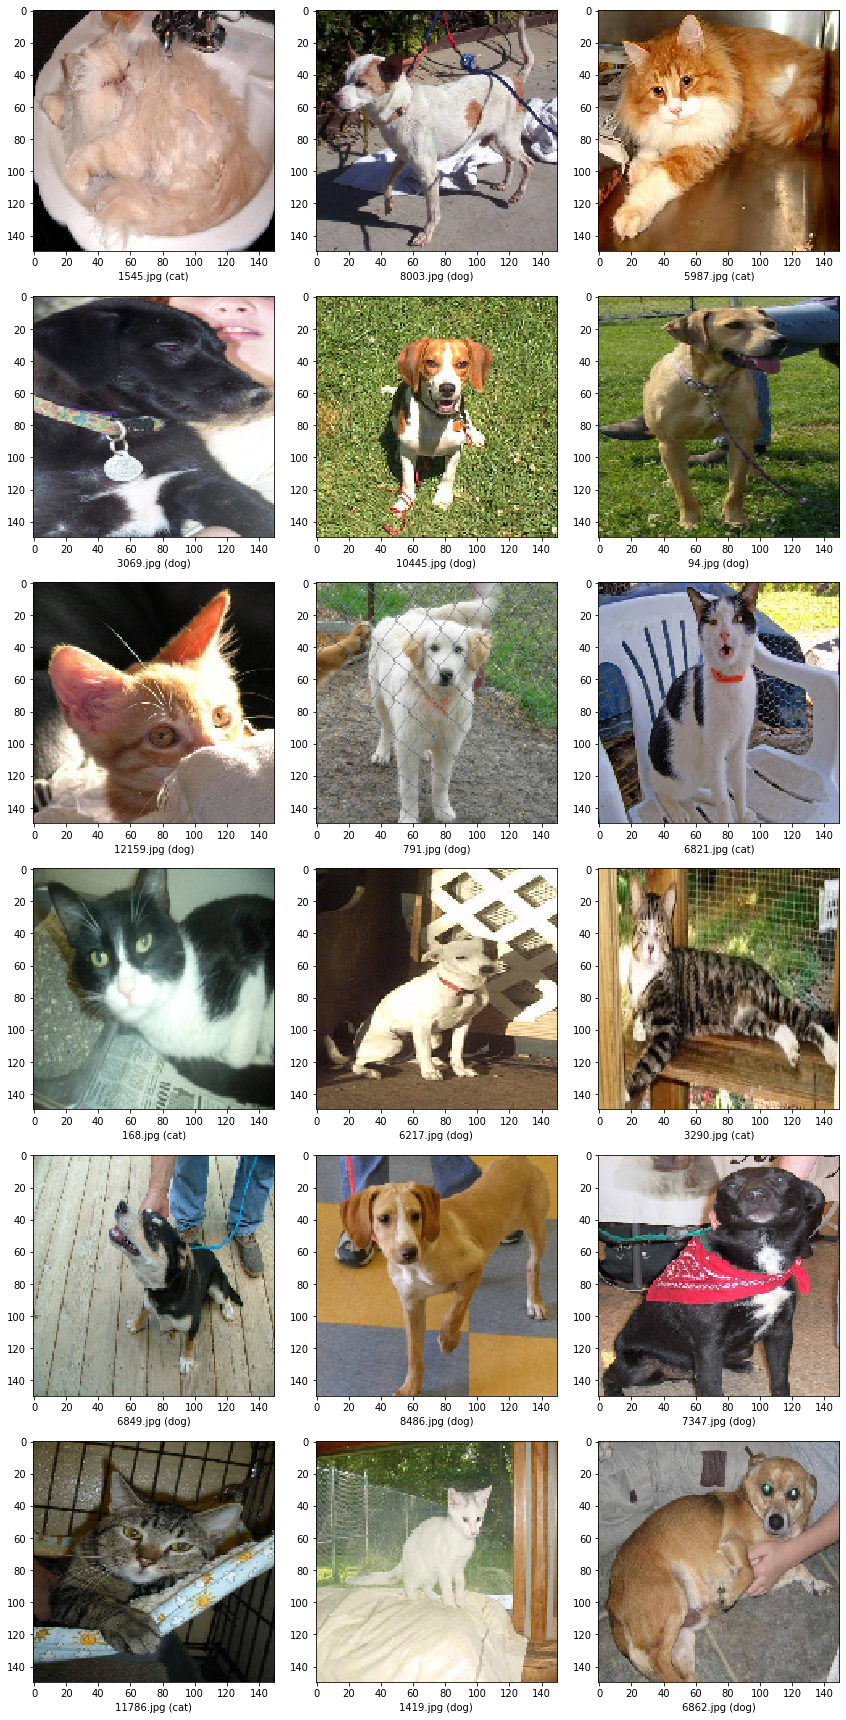

In [44]:
sample_test = test_df.head(18)
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    id = row['id']
    category = "dog" if row['label'] >= 0.5 else "cat"
    img = load_img('test/'+filename, target_size=(IMG_SHAPE,IMG_SHAPE))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(id + '.jpg (' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

#### Submission to Kaggle

In [0]:
test_df[['id','label']].to_csv('withDataAug_3.csv', index=False)

In [0]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f withDataAug_3.csv -m "My third submission with data augmentation"

100% 191k/191k [00:02<00:00, 92.4kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition